In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)


In [5]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [6]:
inspector = inspect(engine)
tables = inspector.get_table_names()

In [7]:
for table in tables:
    print(f"----{table}----")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"])

----measurement----
id
station
date
prcp
tobs
----station----
id
station
name
latitude
longitude
elevation


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest

('2017-08-23')

In [11]:
latest=latest[0]
latest

'2017-08-23'

In [15]:
latest=dt.datetime.strptime(latest,"%Y-%m-%d")

In [16]:
start_date = latest-dt.timedelta(days=365)
start_date
#it annoyed me to not be able to do years but 2017 wasn't a leap year so , I GUESS

datetime.datetime(2016, 8, 23, 0, 0)

In [17]:
year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > start_date).all()

In [18]:
date = [] 
precipitation = []

for y in year:
    date.append(y.date)
    precipitation.append(y.prcp)

In [19]:
year_df = pd.DataFrame({"date": date, "precipitation": precipitation})

In [20]:
year_df.head()

,date,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [21]:
year_df = year_df.set_index("date")

In [22]:
year_df = year_df.sort_index()

In [23]:
year_df = year_df.fillna(0)

In [24]:
year_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,0.00
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


In [45]:
xtick_range = range(len(year_df.index))
xticks_locs = np.arange(0, len(year_df.index), 200)

In [46]:
xticks_labels = []
x=xtick_range[0]

while x in xtick_range:
    xticks_labels.append(year_df.index[x])
    x=x+200

In [47]:
xticks_labels

['2016-08-24',
 '2016-09-24',
 '2016-10-25',
 '2016-11-27',
 '2016-12-28',
 '2017-01-29',
 '2017-03-01',
 '2017-04-03',
 '2017-05-05',
 '2017-06-09',
 '2017-07-11',
 '2017-08-17']

In [48]:
xticks_locs

array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000,
       2200])

In [26]:
xticks=np.arange(0,2300,100)

In [27]:
xticks=['2016-08-24', '2016-10-01', '2016-11-09']

In [28]:
year_df.index[0]

'2016-08-24'

ConversionError: Failed to convert value(s) to axis units: ['2016-08-24', '2016-09-24', '2016-10-25', '2016-11-27', '2016-12-28', '2017-01-29', '2017-03-01', '2017-04-03', '2017-05-05', '2017-06-09', '2017-07-11', '2017-08-17']

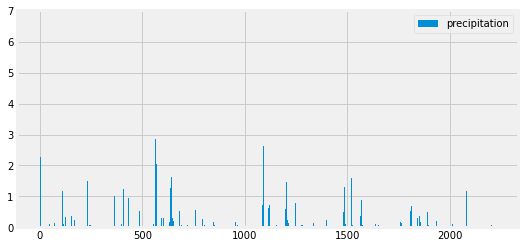

In [44]:
year_df.plot.bar(title="Precipitation in Hawaii", grid=True, xlabel="Date", ylabel="Rain (inches)", figsize=(8,4))

plt.xticks()


In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 



# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame and set the index to the date column


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data




In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data

year_df.describe()

,precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.id)).all()

[(9)]

In [35]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

activity = session.query(func.count(Measurement.date), Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
activity

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station = activity[0][1]
station

'USC00519281'

# Close session

In [ ]:
# Close Session
session.close()